Objective            : Kepala Bank ABC ingin Tim Data Scientist membuat prediksi pembayaran default pada CC Card bulan selanjutnya dengan model klasifikasi. Tujuannya adalah memberi warning kepada pemilik kartu yang pembayaranya di decline bulan depan.        

Dataset Explanation :
- limit_balance : Amount of given credit in NT dollars
- sex : Gender (1=male, 2=female)
- edu_level : Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- marital_status : Marital status (1=married, 2=single, 3=others)
- age : Age in years
- pay_0 - pay_6 : Repayment status in [September - April 2005] 
    (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- bill_amt_1 - bill_amt_6 : Amount of bill statement in [September - April 2005]
- pay_amt_1 - pay_amt_6 : Amount of previous payment in [September - April 2005]
- default_payment_next_month : Default payment (1=yes, 0=no)

# Query

Dataset : Google Bigquery - [Credit Card Default](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=gradedchallenge1&ws=!1m5!1m4!4m3!1sbigquery-public-data!2sml_datasets!3scredit_card_default)

`SELECT limit_balance,
cast (sex as int) as sex,
cast (education_level as int) as edu_level, 
cast (marital_status as int) as marital_status, 
age, 
pay_0, 
pay_2, 
pay_3, 
pay_4, 
cast (pay_5 as float64) as pay_5, 
cast (pay_6 as float64) as pay_6, 
bill_amt_1, 
bill_amt_2, 
bill_amt_3, 
bill_amt_4, 
bill_amt_5, 
bill_amt_6, 
pay_amt_1, 
pay_amt_2, 
pay_amt_3, 
pay_amt_4, 
pay_amt_5, 
pay_amt_6, 
cast (default_payment_next_month as int) as  default_payment_next_month 
FROM `bigquery-public-data.ml_datasets.credit_card_default` 
LIMIT 11982`

# Import Library

In [1]:
#Import Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


#Preprocessing and Modelling
import phik
from phik.report import plot_correlation_matrix
import sklearn
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

#Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Save Modelling
import joblib
import pickle

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

# **Data Loading**

In [2]:
#Load Data
df = pd.read_csv('dataset.csv')

In [3]:
#Shows 10 head data
df.head(10)


,limit_balance,sex,edu_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [4]:
#Shows 10 tail data
df.tail(10)

,limit_balance,sex,edu_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [5]:
#Get overview dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   edu_level                   2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

Pada dataset ini terdapat 2965 baris dan 24 kolom yang berisi mengenai pembayaran kartu kredit, dan usia,tingkat pendidikan, status pernikahan, dan limit balance penggunanya. Terdapat 20 kolom dengan tipe float dan 4 kolom tipe integer.  Berdasarkan overview, tidak terdapat data null di dataset ini, sehingga tidak dilakukan pengecekan missing value secara manual.

### Data Cleaning

In [6]:
#check duplicate data
print('Duplicates :', df.duplicated().sum())

Duplicates : 1


Terdapat 1 data duplikat, maka akan dilakukan drop.

In [7]:
#Drop duplicate data
df.drop_duplicates(inplace=True)

Pada keterangan dataset, pendidikan memiliki nilai `5` dan `6` yang memiliki arti `unknown`. Maka angka `6` akan diubah menjadi angka `5` karena sama.

In [8]:
df['edu_level'].replace({6:5}, inplace=True)

# **Exploratory Data Analysis (EDA)**

In [9]:
#Shows the distribution
df.describe()

,limit_balance,sex,edu_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,...,2964.000000,2964.000000,2964.000000,2964.000000,2.964000e+03,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000
mean,163356.950067,1.607625,1.848516,1.560054,35.193657,0.004723,-0.121795,-0.141026,-0.184548,-0.224696,...,44104.558367,40969.898448,39786.491228,6351.044872,6.274611e+03,5152.234818,4562.914980,4914.944332,5384.517544,0.214238
std,125049.701016,0.488362,0.771800,0.522304,9.110949,1.114434,1.180479,1.183337,1.178049,1.158739,...,61912.600106,58276.878626,57308.498646,20888.933729,2.888432e+04,14289.177313,13283.476236,16736.920951,17278.585006,0.410362
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2585.000000,1974.500000,1433.000000,1013.000000,9.975000e+02,479.250000,313.750000,325.250000,175.250000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19895.000000,18819.500000,18511.500000,2238.000000,2.182500e+03,1997.000000,1600.000000,1646.500000,1626.500000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58638.500000,53414.500000,52297.000000,5089.500000,5.000000e+03,4500.000000,4000.250000,4021.000000,4081.750000,0.000000
max,800000.000000,2.000000,5.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,...,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


Dapat dilihat bahwa :
- rata-rata limit balance yang dimiliki pengguna Bank ABC adalah $ 163.356
- limit balance minimum pada Bank ABC adalah $10.000 dan maksimumnya $800.000
- range usia pengguna CC Bank ABC adalah 26-44 tahun 

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

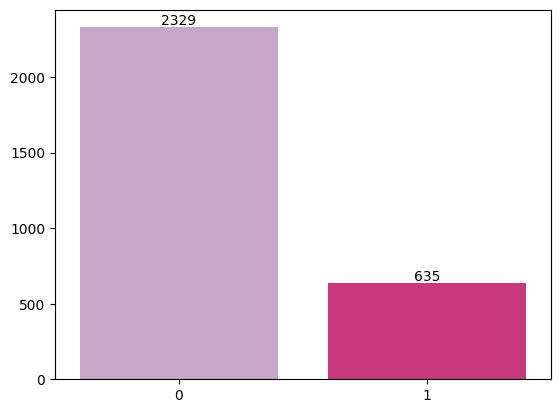

In [10]:
#show default payment distribution
sd = sns.barplot(x=df['default_payment_next_month'].value_counts().index,
            y=df['default_payment_next_month'].value_counts().values, palette='PuRd')

plt.bar_label(sd.containers[0])
plt.xticks()

Berdasarkan grafik, diketahui bahwa terdapat 635 pengguna kartu kredit yang akan diberikan warning pembekuan kartu kredit (1), sedangkan 2329 orang lainnya tidak diberikan warning karena pembayaran kartu kreditnya tepat waktu (0).

Selanjutnya akan dilakukan analisis demografi pada pengguna kartu kredit yang mendapatkan warning pembekuan kartu.

In [11]:
#create declined CC Card Dataframe
dfdec = df.loc[df['default_payment_next_month'] == 1]

(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '2')])

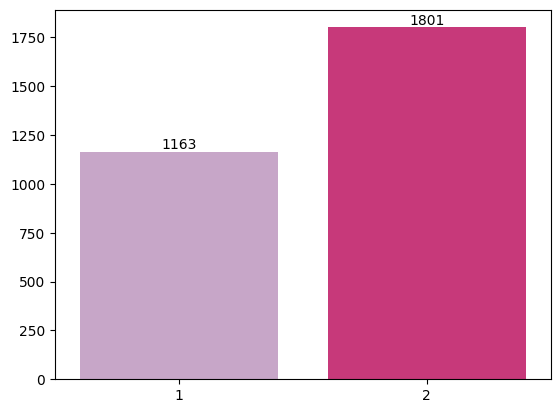

In [12]:
#group declined CC card by sex
sex = sns.barplot(x=dfdec['sex'].value_counts().index,
            y=df['sex'].value_counts().values, palette='PuRd')

plt.bar_label(sex.containers[0])
plt.xticks()

Mayoritas pengguna yang akan didecline kartunya adalah yang berjenis kelamin perempuan. Asumsi peneliti adalah karena perempuan lebih berisiko untuk impulsive buying sehingga akhirnya credit terlalu banyak dan tidak bisa membayarnya.

(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '5')])

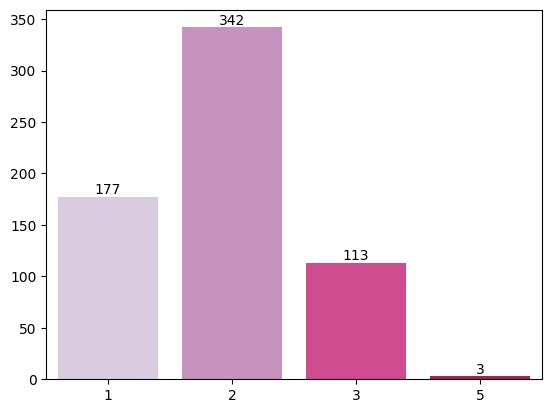

In [13]:
#group declined CC card by edu_level
edu = sns.barplot(x=dfdec['edu_level'].value_counts().index,
            y=dfdec['edu_level'].value_counts().values, palette='PuRd')

plt.bar_label(edu.containers[0])
plt.xticks()

Mayoritas pengguna yang akan didecline kartunya adalah yang memiliki tingkat pendidikan terakhir di Universitas. Namun hal ini tidak dapat menggambarkan keterkaitan karena saat ini kebanyakan masyarakat memiliki pendidikan terakhir di Universitas karena berkembangnya ilmu pendidikan.

(array([0, 1, 2]), [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')])

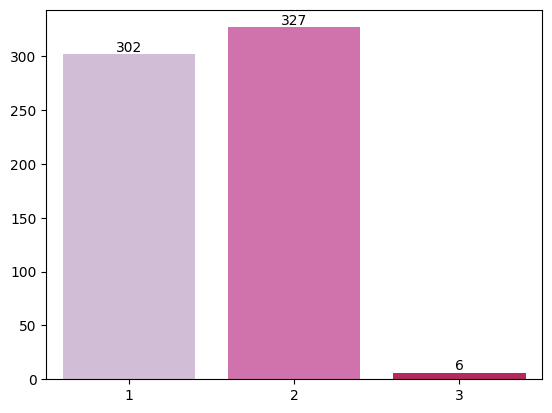

In [14]:
#group declined CC card by marital_status
marital = sns.barplot(x=dfdec['marital_status'].value_counts().index,
            y=dfdec['marital_status'].value_counts().values, palette='PuRd')

plt.bar_label(marital.containers[0])
plt.xticks()

Mayoritas pengguna yang akan didecline kartunya adalah yang berstatus single, namun distribusinya tidak berbeda signifikan dengan yang berstatus menikah. Hal ini dapat didefinisikan bahwa status perkawinan tidak terlalu berhubungan dengan penunggakan bayar pada pelanggan CC karena distribusinya sama. 

<Axes: >

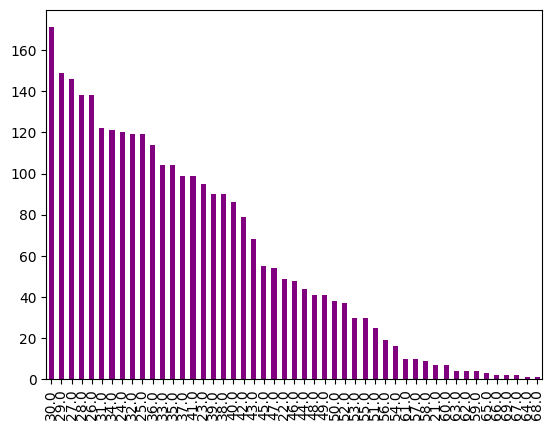

In [15]:
df['age'].value_counts().sort_values(ascending=False).plot(kind='bar', color='Purple')

Mayoritas pengguna yang akan di declined berusia antara 26-40 tahun dan 5 kelompok usia yang paling banyak di declined berusia 26-30 tahun. Hal ini bisa  terjadi kemungkinan pada usia 26-40 tahun, banyak yang sudah berkeluarga sehingga kebutuhannya meningkat. Namun pemasukan yang sedikit atau pengelolaan uang yang buruk menyebabkan tidak bisa membayar credit.

# **Feature Engineering**

### Feature Selection

In [16]:
#Group columns which have intervals
interval_cols = ['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2',
       'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1',
       'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']

#calculate correlation with phik
phik_overview = df.phik_matrix(interval_cols=interval_cols)

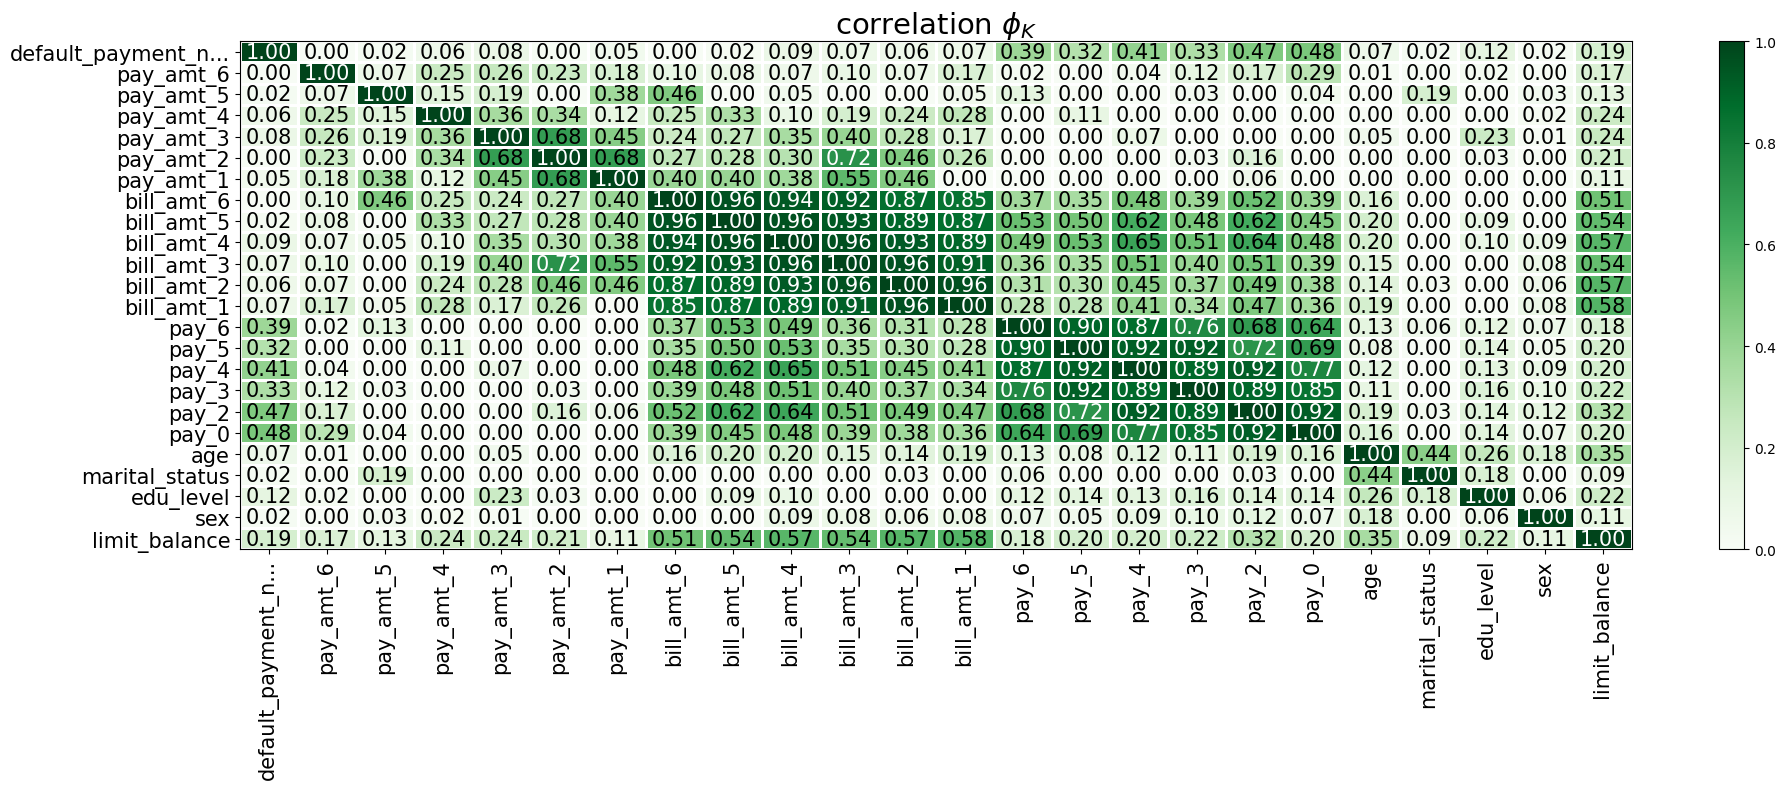

In [17]:
#Shows correlation graphs
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 8))
plt.tight_layout()

Untuk memprediksi apakah kartu CC akan dibekukan, bisa dilihat dari status pembayaran setiap bulannya yaitu pada kolom `pay_0 - pay_6`. Hal ini dibuktikan dengan grafik korelasi apabila menggunakan treshold 0.3, maka kolom yang memiliki korelasi dengan `default_payment_next_month` adalah kolom `pay_0 - pay_6`. 

Selasin itu perlu pembuktian korelasi secara statistik dengan significance matrix sebagai berikut :

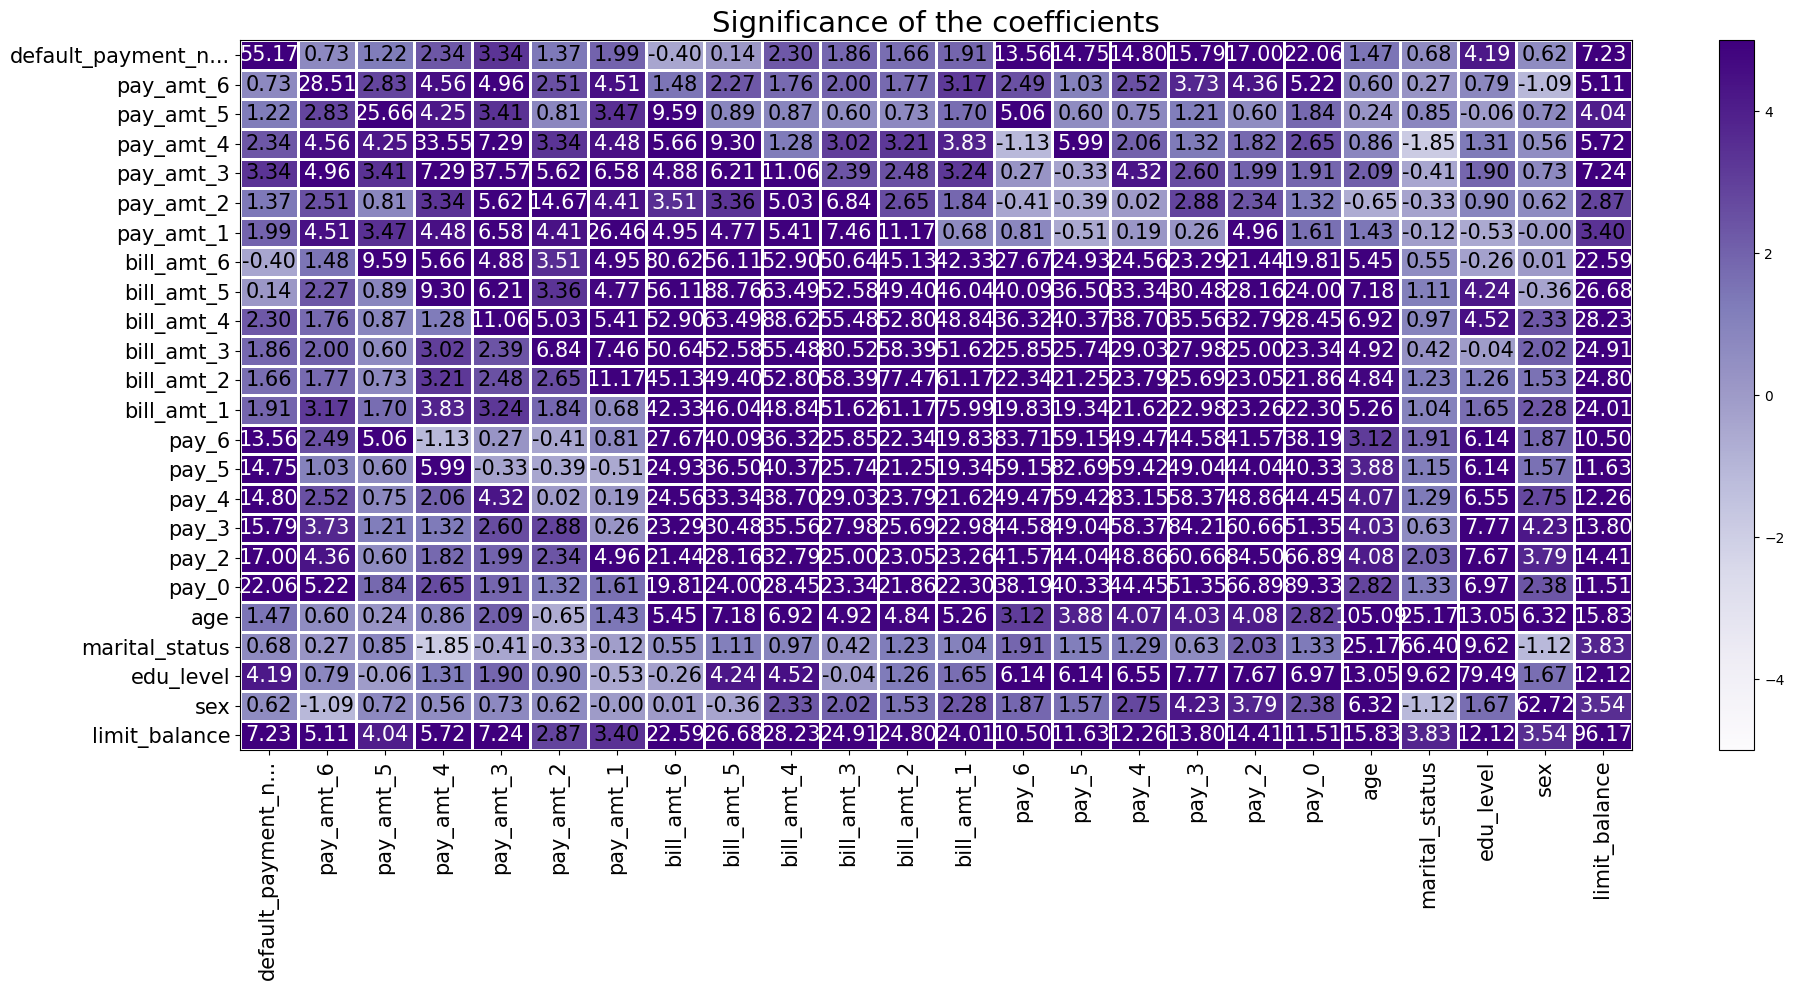

In [18]:
#shows siginificance graph
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(20, 10), color_map='Purples')
plt.tight_layout()

Berdasarkan siginificance matrix, kolom `pay_0 - pay_6` memiliki siginificance/korelasi tinggi (nilai diatas 10). Sehingga elanjutnya akan dibuat dataframe baru yang berisi `default_payment_next_month` yang didefinisikan sebagai target dan `pay_0 - pay_6` yang didefinisikan sebagai fitur. 

In [19]:
#create new datafrane
dfnew = df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'default_payment_next_month']]
dfnew

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,default_payment_next_month
0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,-1.0,0.0,0.0,0
...,...,...,...,...,...,...,...
2960,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,0
2961,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1
2962,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1
2963,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0


### Cardinality Check

Nilai pada `pay_0 - pay_6` adalah data kategorik karena merupakan representasi dari status pembayaran. Oleh karena itu, akan dilakukan cek kardinalitas data.

In [20]:
#cardinality check
for i in dfnew:
    print(i)
    print(df[i].nunique())
    print('-'*30)

pay_0
11
------------------------------
pay_2
10
------------------------------
pay_3
9
------------------------------
pay_4
10
------------------------------
pay_5
9
------------------------------
pay_6
8
------------------------------
default_payment_next_month
2
------------------------------


In [21]:
#show unique values in feature columns
for i in dfnew:
    print(i)
    print(df[i].unique())
    print('-'*30)

pay_0
[ 0.  2.  1. -1. -2.  3.  4.  5.  6.  7.  8.]
------------------------------
pay_2
[ 0. -1.  2.  3. -2.  4.  1.  5.  6.  7.]
------------------------------
pay_3
[ 0.  2. -2.  3. -1.  4.  5.  6.  7.]
------------------------------
pay_4
[ 0. -1.  2.  3.  4.  5.  6.  7.  8. -2.]
------------------------------
pay_5
[ 0.  2.  3.  4.  5.  6.  7. -1. -2.]
------------------------------
pay_6
[ 0. -1.  2.  3. -2.  4.  6.  7.]
------------------------------
default_payment_next_month
[1 0]
------------------------------


Pada setiap kolom `pay_`, memiliki variasi kardinalitas yang berbeda namun memiliki nilai yang sama. Sehingga akan dilakukan handling kardinalitas ke semua kolom `pay_`, yaitu dengan menggabungkan value `-2`, `-1`, dan `0` yang memiliki definisi bahwa pelanggan melakukan pembayaran tepat waktu dengan nilai `-1`

In [22]:
#replace values
dfnew[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']] = dfnew[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].replace({-2:-1,0:-1})

In [23]:
#show updated dfnew
dfnew

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,default_payment_next_month
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
...,...,...,...,...,...,...,...
2960,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
2961,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2962,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2963,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0


Data pada feature merupakan data kategorikal, sehingga tidak dilakukan perhitungan nilai VIF.

Kemudian akan dilakukan pengecekan distribusi data pada kolom target

In [24]:
#fungsi plot sebaran data
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    plt.show()

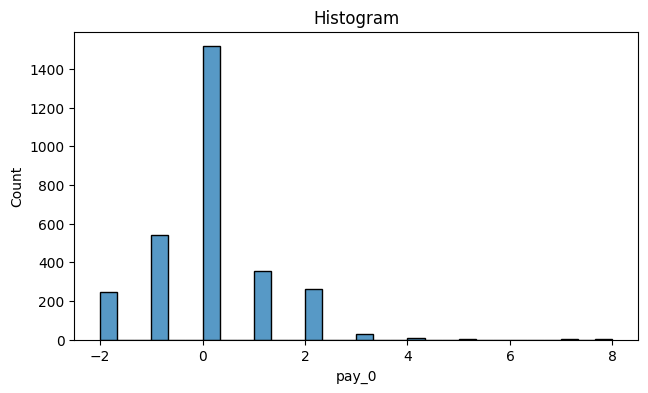


Skewness Value :  0.9276720756106166


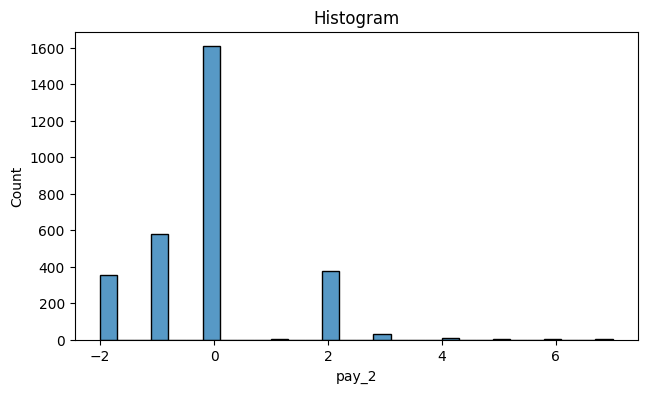


Skewness Value :  0.8624687970101019


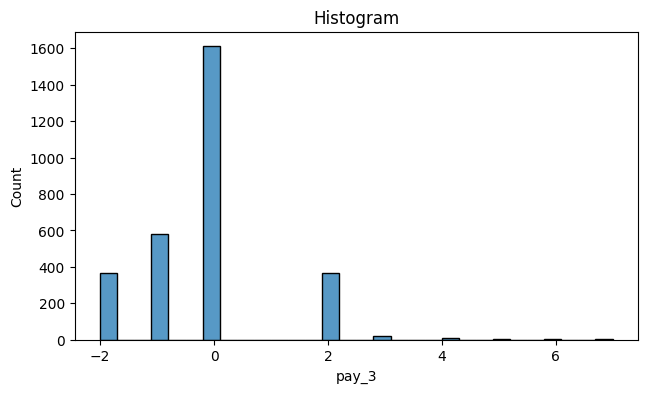


Skewness Value :  0.9321840116222396


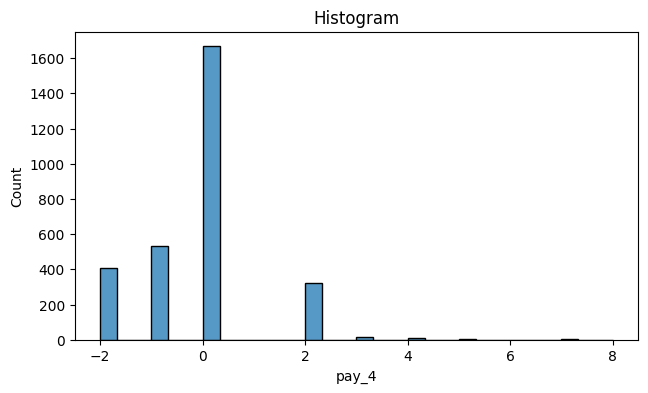


Skewness Value :  1.102317023326789


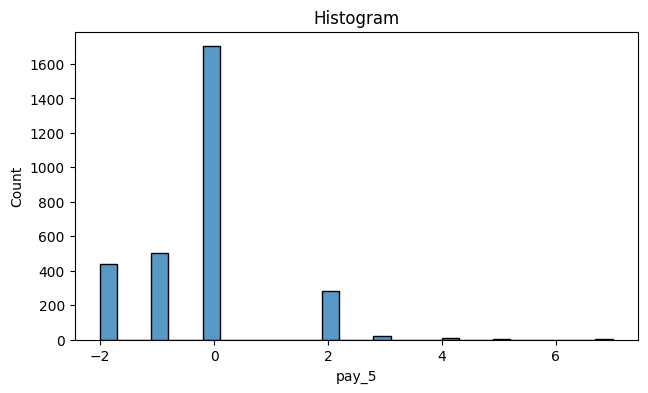


Skewness Value :  1.060916090705517


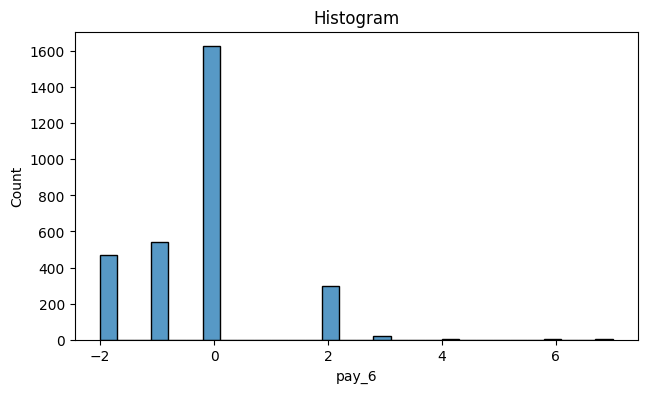


Skewness Value :  0.9793187194607118


In [25]:
#melihat distribusi
diagnostic_plots(df, 'pay_0')
print('\nSkewness Value : ', df['pay_0'].skew())

#melihat gambaran pada kolom hours_per_week
diagnostic_plots(df, 'pay_2')
print('\nSkewness Value : ', df['pay_2'].skew())

#melihat gambaran pada kolom hours_per_week
diagnostic_plots(df, 'pay_3')
print('\nSkewness Value : ', df['pay_3'].skew())

#melihat gambaran pada kolom hours_per_week
diagnostic_plots(df, 'pay_4')
print('\nSkewness Value : ', df['pay_4'].skew())

#melihat gambaran pada kolom hours_per_week
diagnostic_plots(df, 'pay_5')
print('\nSkewness Value : ', df['pay_5'].skew())

#melihat gambaran pada kolom hours_per_week
diagnostic_plots(df, 'pay_6')
print('\nSkewness Value : ', df['pay_6'].skew())

Ditemukan bahwa data target memiliki distribusi normal.

### Split

In [26]:
#Split feature and target
X = dfnew.drop(['default_payment_next_month'], axis=1)
y = dfnew['default_payment_next_month']

In [27]:
#Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=51)

#Shows train-test size
print('Train Size:', X_train.shape)
print('Test Size:', X_test .shape)

Train Size: (2074, 6)
Test Size: (890, 6)


Karena data merupakan data kategorikal, maka tidak dilakukan cek outlier. Selain itu dikarenakan data kategorikal sudah berubah ke dalam bentuk angka dan berurutan sesuai dengan representasi definisinya maka tidak dilakukan encoding/preprocessing data dan langsung masuk ke dalam pemodelan.

# **Model**

Sebelum memilih model terbaik dari scoring, berikut adalah definisi dataset yang perlu diperhatikan :
- Nilai Positive : kelas 1, pengguna yang kartu kreditnya akan di bekukan bulan depan dan akan dikirim pemberitahuan pembekuan kartu kredit 
- Nilai Negative : kelas 0, pengguna yang kartu kreditnya tidak akan dibekukan bulan depan
- Model yang baik adalah model yang dapat memprediksi nilai False Positive paling kecil, dimana pengguna yang tidak akan dibekukan kartu kreditnya namun mendapatkan pemberitahuan pembekuan kartu kredit. Karena hal ini bisa meningkatkan komplain pelanggan dan menimbulkan kepanikan pada pengguna. Sehingga scoring yang akan digunakan yaitu `precision`.

### Logistic Regression

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1630
           1       0.72      0.31      0.44       444

    accuracy                           0.83      2074
   macro avg       0.78      0.64      0.67      2074
weighted avg       0.81      0.83      0.80      2074

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       699
           1       0.70      0.31      0.43       191

    accuracy                           0.82       890
   macro avg       0.77      0.64      0.66       890
weighted avg       0.81      0.82      0.80       890

Confusion Matrix LG     : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002367A757460>


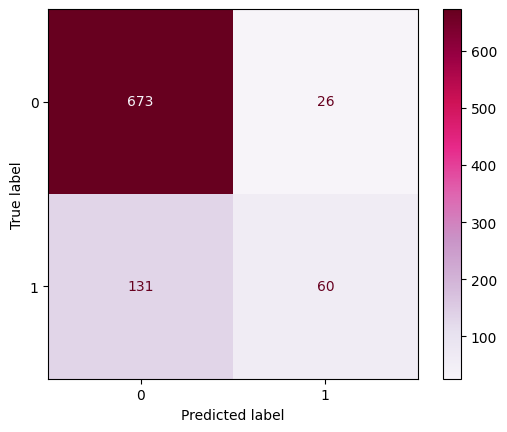

In [28]:
# model definition 
model_LG = LogisticRegression(random_state=0)

#model training
model_LG.fit(X_train, y_train)

#model prediciton
LG_train = model_LG.predict(X_train)
LG_test = model_LG.predict(X_test)

#evaluate model
print(classification_report(y_train, LG_train))
print(classification_report(y_test, LG_test))

#confussion matrix display
print('Confusion Matrix LG     :', ConfusionMatrixDisplay.from_estimator(model_LG, X_test, y_test, cmap='PuRd'))

Pada model Logistic Regression memiliki hasil prediksi 26 orang False Positive. Berdasarkan nilai `precision` , didapatkan bahwa model dapat memprediksi benar pada data train sebanyak 72%, dan pada data test sebanyak 70%. Hal ini menunjukkan bahwa model memiliki performa overfit. 

In [29]:
#cross validation
scores_LG = cross_val_score(model_LG, X_train, y_train,
                         scoring="precision", cv=5)
print('Scores: ', scores_LG)
print('Mean:', scores_LG.mean())
print('Standar Deviasi:', scores_LG.std())

Scores:  [0.71428571 0.61764706 0.73809524 0.68518519 0.725     ]
Mean: 0.6960426392779334
Standar Deviasi: 0.04290340531280854


Setelah dilakukan cross validation, didapatkan bahwa model Logistic Regression memiliki skor rata-rata 0.696 dengan variance 0.043 

### SVM

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1630
           1       0.75      0.44      0.56       444

    accuracy                           0.85      2074
   macro avg       0.81      0.70      0.73      2074
weighted avg       0.84      0.85      0.83      2074

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       699
           1       0.62      0.36      0.46       191

    accuracy                           0.82       890
   macro avg       0.73      0.65      0.67       890
weighted avg       0.80      0.82      0.80       890

Confusion Matrix LG     : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002367AD6E7F0>


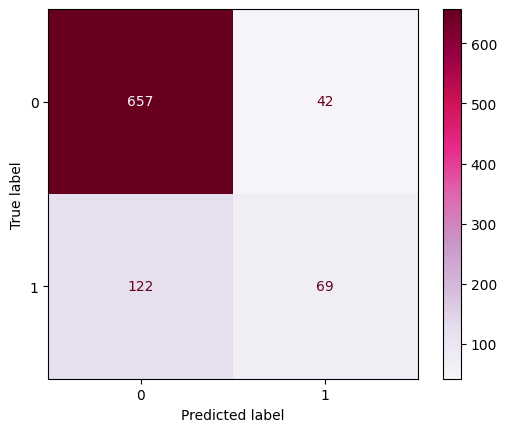

In [30]:
# model definition 
model_SVM = SVC(random_state=0)

#model training
model_SVM.fit(X_train, y_train)

#model prediciton
SVM_train = model_SVM.predict(X_train)
SVM_test = model_SVM.predict(X_test)

#evaluate model
print(classification_report(y_train, SVM_train))
print(classification_report(y_test, SVM_test))

#confussion matrix display
print('Confusion Matrix LG     :', ConfusionMatrixDisplay.from_estimator(model_SVM, X_test, y_test, cmap='PuRd'))

Pada model Support Vector Machine(SVM) memiliki hasil prediksi 42 orang False Positive. Berdasarkan nilai `precision` , didapatkan bahwa model dapat memprediksi benar pada data train sebanyak 75%, dan pada data test sebanyak 62%. Hal ini menunjukkan bahwa model memiliki performa overfit. 

In [31]:
#cross validation
scores_SVM = cross_val_score(model_SVM, X_train, y_train,
                         scoring="precision", cv=5)
print('Scores: ', scores_SVM)
print('Mean:', scores_SVM.mean())
print('Standar Deviasi:', scores_SVM.std())

Scores:  [0.70588235 0.62962963 0.76785714 0.70175439 0.71153846]
Mean: 0.7033323945862646
Standar Deviasi: 0.0439815248378634


Setelah dilakukan cross validation, didapatkan bahwa model Support Vector Machine(SVM) memiliki skor rata-rata 0.703 dengan variance 0.044 

### Decision Tree

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1630
           1       0.80      0.43      0.56       444

    accuracy                           0.85      2074
   macro avg       0.83      0.70      0.74      2074
weighted avg       0.85      0.85      0.84      2074

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       699
           1       0.63      0.35      0.45       191

    accuracy                           0.82       890
   macro avg       0.73      0.64      0.67       890
weighted avg       0.80      0.82      0.79       890



Confusion Matrix LG     : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002367AB0D8B0>


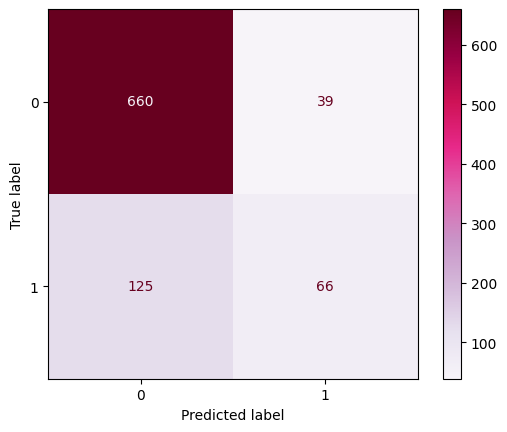

In [32]:
# model definition 
model_DT = DecisionTreeClassifier(random_state=0)

#model training
model_DT.fit(X_train, y_train)

#model prediciton
DT_train = model_DT.predict(X_train)
DT_test = model_DT.predict(X_test)

#evaluate model
print(classification_report(y_train, DT_train))
print(classification_report(y_test, DT_test))

#confussion matrix display
print('Confusion Matrix LG     :', ConfusionMatrixDisplay.from_estimator(model_DT, X_test, y_test, cmap='PuRd'))

Pada model Decision Tree memiliki hasil prediksi 39 orang False Positive. Berdasarkan nilai `precision` , didapatkan bahwa model dapat memprediksi benar pada data train sebanyak 80%, dan pada data test sebanyak 63%. Hal ini menunjukkan bahwa model memiliki performa overfit. 

In [33]:
#cross validation
scores_DT = cross_val_score(model_DT, X_train, y_train,
                         scoring="precision", cv=5)
print('Scores: ', scores_DT)
print('Mean:', scores_DT.mean())
print('Standar Deviasi:', scores_DT.std())

Scores:  [0.68627451 0.61702128 0.76470588 0.69090909 0.63461538]
Mean: 0.6787052288554165
Standar Deviasi: 0.0516742972793778


Setelah dilakukan cross validation, didapatkan bahwa model Decision Tree memiliki skor rata-rata 0.68 dengan variance 0.05 

### Random Forest

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1630
           1       0.76      0.47      0.58       444

    accuracy                           0.85      2074
   macro avg       0.81      0.71      0.75      2074
weighted avg       0.85      0.85      0.84      2074

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       699
           1       0.62      0.41      0.49       191

    accuracy                           0.82       890
   macro avg       0.74      0.67      0.69       890
weighted avg       0.80      0.82      0.80       890

Confusion Matrix LG     : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002367AF02A90>


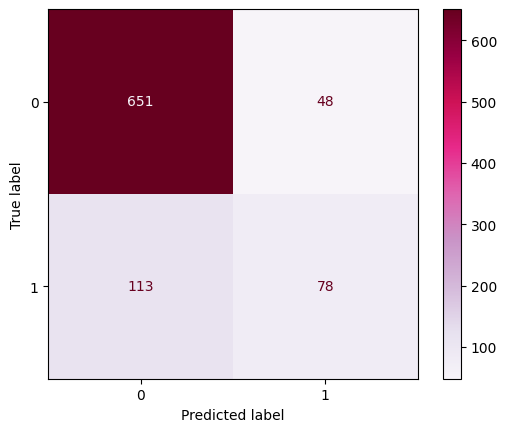

In [34]:
# model definition 
model_RF = RandomForestClassifier(random_state=0)

#model training
model_RF.fit(X_train, y_train)

#model prediciton
RF_train = model_RF.predict(X_train)
RF_test = model_RF.predict(X_test)

#evaluate model
print(classification_report(y_train, RF_train))
print(classification_report(y_test, RF_test))

#confussion matrix display
print('Confusion Matrix LG     :', ConfusionMatrixDisplay.from_estimator(model_RF, X_test, y_test, cmap='PuRd'))

Pada model Random Forest memiliki hasil prediksi 42 orang False Positive. Berdasarkan nilai `precision` , didapatkan bahwa model dapat memprediksi benar pada data train sebanyak 76%, dan pada data test sebanyak 62%. Hal ini menunjukkan bahwa model memiliki performa overfit. 

In [35]:
#cross validate
scores_RF = cross_val_score(model_RF, X_train, y_train,
                         scoring="precision", cv=5)
print('Scores: ', scores_RF)
print('Mean:', scores_RF.mean())
print('Standar Deviasi:', scores_RF.std())

Scores:  [0.68421053 0.64       0.74074074 0.69354839 0.63636364]
Mean: 0.6789726581033881
Standar Deviasi: 0.03844367304266375


Setelah dilakukan cross validation, didapatkan bahwa model Random Forest memiliki skor rata-rata 0.69 dengan variance 0.038

### KNN

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1630
           1       0.77      0.32      0.46       444

    accuracy                           0.83      2074
   macro avg       0.81      0.65      0.68      2074
weighted avg       0.83      0.83      0.81      2074

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       699
           1       0.68      0.28      0.40       191

    accuracy                           0.82       890
   macro avg       0.75      0.62      0.65       890
weighted avg       0.80      0.82      0.79       890

Confusion Matrix LG     : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002367A6A6F40>


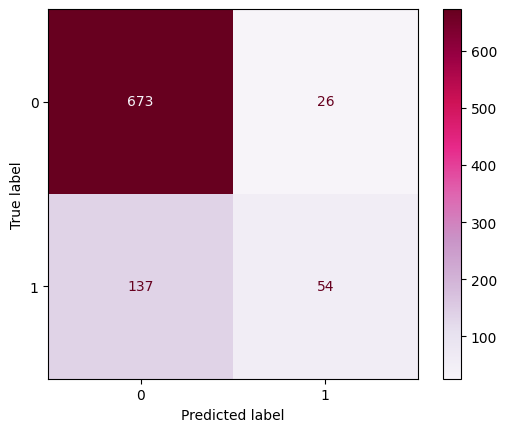

In [36]:
# model definition 
model_KNN = KNeighborsClassifier()

#model training
model_KNN.fit(X_train, y_train)

#model prediciton
KNN_train = model_KNN.predict(X_train)
KNN_test = model_KNN.predict(X_test)

#evaluate model
print(classification_report(y_train, KNN_train))
print(classification_report(y_test, KNN_test))

#confussion matrix display
print('Confusion Matrix LG     :', ConfusionMatrixDisplay.from_estimator(model_KNN, X_test, y_test, cmap='PuRd'))

Pada model K-Nearest Neighbours memiliki hasil prediksi 26 orang False Positive. Berdasarkan nilai `precision` , didapatkan bahwa model dapat memprediksi benar pada data train sebanyak 77%, dan pada data test sebanyak 68%. Hal ini menunjukkan bahwa model memiliki performa overfit. 

In [37]:
scores_KNN = cross_val_score(model_KNN, X_train, y_train,
                         scoring="precision", cv=5)
print('Scores: ', scores_KNN)
print('Mean:', scores_KNN.mean())
print('Standar Deviasi:', scores_KNN.std())

Scores:  [0.66666667 0.51851852 0.81395349 0.6031746  0.59649123]
Mean: 0.6397609009604114
Standar Deviasi: 0.09897223329328517


Setelah dilakukan cross validation, didapatkan bahwa model K-Nearest Neighbours memiliki skor rata-rata 0.64 dengan variance 0.1 

### Naive Baiyes-Gaussian Classifier

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1630
           1       0.54      0.47      0.50       444

    accuracy                           0.80      2074
   macro avg       0.70      0.68      0.69      2074
weighted avg       0.79      0.80      0.80      2074

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       699
           1       0.54      0.50      0.52       191

    accuracy                           0.80       890
   macro avg       0.70      0.69      0.70       890
weighted avg       0.80      0.80      0.80       890



Confusion Matrix LG     : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002367C852CD0>


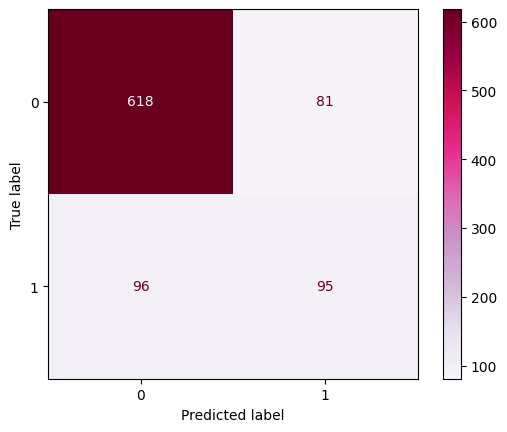

In [38]:
# model definition 
model_NB = GaussianNB() #karena distribusi normal

#model training
model_NB.fit(X_train, y_train)

#model prediciton
NB_train = model_NB.predict(X_train)
NB_test = model_NB.predict(X_test)

#evaluate model
print(classification_report(y_train, NB_train))
print(classification_report(y_test, NB_test))

#confussion matrix display
print('Confusion Matrix LG     :', ConfusionMatrixDisplay.from_estimator(model_NB, X_test, y_test, cmap='PuRd'))

Pada Naive Bayes, digunakan model Gaussian karena pada kolom target memiliki distribusi normal. Model ini memiliki hasil prediksi 81 orang False Positive. Berdasarkan nilai `precision` , didapatkan bahwa model dapat memprediksi benar pada data train sebanyak 54%, dan pada data test sebanyak 54%. Hal ini menunjukkan bahwa model memiliki performa underfit karena train dan test performanya kurang bagus. 

In [39]:
#cross validation
scores_NB = cross_val_score(model_NB, X_train, y_train,
                         scoring="precision", cv=5)
print('Scores: ', scores_NB)
print('Mean:', scores_NB.mean())
print('Standar Deviasi:', scores_NB.std())

Scores:  [0.57692308 0.47761194 0.56578947 0.5        0.56962025]
Mean: 0.5379889488140703
Standar Deviasi: 0.04093364952911807


Setelah dilakukan cross validation, didapatkan bahwa model Naive Bayes memiliki skor rata-rata 0.53 dengan variance 0.04 

### Bagging Classifier

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1630
           1       0.76      0.46      0.58       444

    accuracy                           0.85      2074
   macro avg       0.82      0.71      0.74      2074
weighted avg       0.85      0.85      0.84      2074

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       699
           1       0.64      0.40      0.49       191

    accuracy                           0.82       890
   macro avg       0.75      0.67      0.69       890
weighted avg       0.81      0.82      0.81       890

Confusion Matrix LG     : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002367C78C0D0>


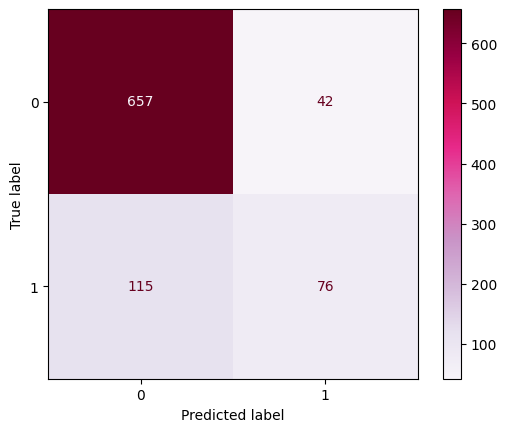

In [40]:
# model definition 
model_BC = BaggingClassifier()

#model training
model_BC.fit(X_train, y_train)

#model prediciton
BC_train = model_BC.predict(X_train)
BC_test = model_BC.predict(X_test)

#evaluate model
print(classification_report(y_train, BC_train))
print(classification_report(y_test, BC_test))

#confussion matrix display
print('Confusion Matrix LG     :', ConfusionMatrixDisplay.from_estimator(model_BC, X_test, y_test, cmap='PuRd'))

Pada model Bagging Classifier ini memiliki hasil prediksi 44 orang False Positive. Berdasarkan nilai `precision` , didapatkan bahwa model dapat memprediksi benar pada data train sebanyak 77%, dan pada data test sebanyak 62%. Hal ini menunjukkan bahwa model memiliki performa overfit.

In [41]:
#cross validation
scores_BC = cross_val_score(model_BC, X_train, y_train,
                         scoring="precision", cv=5)
print('Scores: ', scores_BC)
print('Mean:', scores_BC.mean())
print('Standar Deviasi:', scores_BC.std())

Scores:  [0.7        0.63461538 0.78       0.6779661  0.72916667]
Mean: 0.7043496305953932
Standar Deviasi: 0.04881954243205367


Setelah dilakukan cross validation, didapatkan bahwa model ini memiliki skor rata-rata 0.68 dengan variance 0.04 

## Model Selection

Diantara 7 model yang telah dibuat, didapatkan bahwa model **Logistic Regression** adalah model yang terbaik karena meskipunoverfit, namun perbedaan antara nilai train dan test hanya 0.02. Selain itu model Logistic Regression dapat memprediksi nilai False Positive paling kecil diantara model lainnya. Namun untuk mengoptimalkan hasil, akan dilakukan Hyperparameter Tuning pada model.

**Hyperparameter Tuning Logistic Regression Model**

In [42]:
#define parameters
params = {
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear','saga'],
    'C' : [0.1,5.,10.,]  
}

Hyperparameter tuning dilakukan dengan metode Randomized Search Cross Validation karena secara efisiensi waktu, randomized lebih cepat dibandingkan dengan Grid Searc Cross Validation.

In [43]:
#define random search
random_search = RandomizedSearchCV(model_LG, params, cv=5,
                           scoring='precision',
                           return_train_score=True)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
                   param_distributions={'C': [0.1, 5.0, 10.0],
                                        'penalty': ['l2', 'l1'],
                                        'solver': ['liblinear', 'saga']},
                   return_train_score=True, scoring='precision')

In [44]:
#show best parameter
random_search.best_params_

{'solver': 'saga', 'penalty': 'l1', 'C': 0.1}

Ditemukan bahwa parameter terbaik yaitu model yang `solver` = `saga`, `penalty` = `L1`, dan `C`=0.1

In [45]:
#show score before tuning
print('Skor sebelum tuning :', scores_LG.mean())

#show after tuning
print('Skor setelah tuning :', random_search.best_score_)

Skor sebelum tuning : 0.6960426392779334
Skor setelah tuning : 0.7194117647058824


Setelah dilakukan hyperparameter tuning, skor meningkat sebanyak 0.02.

In [46]:
#save newest model and evaluate
model = random_search.best_estimator_

model.fit(X_train, y_train)

model_train = model.predict(X_train)
model_test = model.predict(X_test)

print(classification_report(y_train, model_train))
print(classification_report(y_test, model_test))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1630
           1       0.72      0.32      0.44       444

    accuracy                           0.83      2074
   macro avg       0.78      0.64      0.67      2074
weighted avg       0.81      0.83      0.80      2074

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       699
           1       0.71      0.30      0.42       191

    accuracy                           0.82       890
   macro avg       0.77      0.63      0.66       890
weighted avg       0.81      0.82      0.79       890



Didapatkan bahwa nilai test meningkat jadi 0.71 sehingga gap antara train dan test adalah 0.01 dan bisa dikatakan sebagai goodfit.

# Model Saving

Menyimpan model untuk melakukan prediksi pada dataset baru 

In [47]:
#model saving
with open('model.pkl', 'wb') as Model_Predict:
  pickle.dump(model, Model_Predict)

# Conclusion

Pada Objective, tujuan dibuat model ini adalah untuk memprediksi apakah seseorang akan diberikan decline CC warning bulan depan berdasarkan status paymentnya setiap bulan. Dari 7 model yang dibuat, ditemukan bahwa model **Logistic Regression** adalah model yang terbaik karena dapat memprediksi nilai False Positive paling kecil yaitu 26 orang serta memiliki mean score precision pada cross validation paling tinggi yaitu sebesar 0.69. Setelah itu dilakukan Hyperparameter Tuning untuk mengoptimalkan model yang telah dibuat dan didapatkan parameter terbaik adalah `solver` = `saga`, `penalty` = `L1`, dan `C`=0.1 dan dipatakan skor precision terbaiknya 0.71, yang berarti ada peningkatan skor setelah model dilakukan hyperparameter tuning.

Sehingga model ini dapat melakukan prediksi dengan probabilitas benar yaitu 0.71.